In [1]:
!pip install -q sentence-transformers

In [2]:
import pandas as pd
import pickle
import os
from sentence_transformers import SentenceTransformer

# Create model directory if it doesn't exist
os.makedirs("../model", exist_ok=True)

In [3]:
# Load the CSV file
df = pd.read_csv("../data/Final_Augmented_dataset_Diseases_and_Symptoms.csv")

# Extract all symptom column names (excluding 'diseases')
all_symptoms = df.columns.tolist()
all_symptoms.remove("diseases")

# Save the list of symptoms for use in app
with open("../model/model_all_symptoms.pkl", "wb") as f:
    pickle.dump(all_symptoms, f)

In [4]:
# Load pretrained SentenceTransformer model
model = SentenceTransformer("all-MiniLM-L6-v2")

# Create a dictionary mapping symptom → vector
symptom_embeddings = {symptom: model.encode(symptom) for symptom in all_symptoms}

# Save the embeddings
with open("../model/model_symptom_embeddings.pkl", "wb") as f:
    pickle.dump(symptom_embeddings, f)

In [16]:
import re
import nltk
from nltk.corpus import stopwords
from sentence_transformers import util, SentenceTransformer
import pickle

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Load models
with open("../model/model_symptom_embeddings.pkl", "rb") as f:
    symptom_embeddings = pickle.load(f)

symptom_list = list(symptom_embeddings.keys())
symptom_vectors = list(symptom_embeddings.values())

model = SentenceTransformer("all-MiniLM-L6-v2")

# Clean and extract keywords from user message
def clean_input(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # remove punctuation
    words = text.split()
    filtered = [word for word in words if word not in stop_words]
    return " ".join(filtered)

# Match to top symptoms
def extract_symptoms_cleaned(user_input, top_k=10):
    cleaned = clean_input(user_input)
    input_vec = model.encode(cleaned, convert_to_tensor=True)
    input_vec = input_vec.cpu()  # ✅ force to CPU to match stored embeddings

    scores = [(symptom, float(util.cos_sim(input_vec, vec))) for symptom, vec in symptom_embeddings.items()]
    top_matches = sorted(scores, key=lambda x: x[1], reverse=True)[:top_k]
    return top_matches

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jeetshah/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
test_input = "chest pain left arm pain and heartbeat irregular"
print("Cleaned:", clean_input(test_input))
for symptom, score in extract_symptoms_cleaned(test_input):
    print(f"{symptom} → score: {score:.4f}")

Cleaned: chest pain left arm pain heartbeat irregular
irregular heartbeat → score: 0.7081
sharp chest pain → score: 0.6815
burning chest pain → score: 0.6135
arm pain → score: 0.5616
arm cramps or spasms → score: 0.5108
congestion in chest → score: 0.4910
muscle pain → score: 0.4876
lower body pain → score: 0.4666
shoulder pain → score: 0.4651
shoulder cramps or spasms → score: 0.4625


In [19]:
df = pd.read_csv("../data/Final_Augmented_dataset_Diseases_and_Symptoms.csv")
df.head()

,diseases,anxiety and nervousness,depression,shortness of breath,depressive or psychotic symptoms,sharp chest pain,dizziness,insomnia,abnormal involuntary movements,chest tightness,...,stuttering or stammering,problems with orgasm,nose deformity,lump over jaw,sore in nose,hip weakness,back swelling,ankle stiffness or tightness,ankle weakness,neck weakness
0,panic disorder,1,0,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,panic disorder,0,0,1,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,panic disorder,1,1,1,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,panic disorder,1,0,0,1,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,panic disorder,1,1,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [21]:
from collections import defaultdict
import pickle

# 1. Extract all symptoms (excluding 'diseases' column)
symptom_columns = [col for col in df.columns if col != "diseases"]

# 2. Create a nested dictionary: disease → symptom → confidence
symptom_confidence = defaultdict(dict)

# 3. Loop through each disease
for disease in df['diseases'].unique():
    disease_rows = df[df['diseases'] == disease]
    total = len(disease_rows)
    
    for symptom in symptom_columns:
        present = disease_rows[symptom].sum()
        confidence = present / total if total > 0 else 0
        if confidence > 0:
            symptom_confidence[disease][symptom] = round(confidence, 3)

# 4. Save to pickle
with open("../model/symptom_confidence_scores.pkl", "wb") as f:
    pickle.dump(dict(symptom_confidence), f)

print("✅ Saved: model/symptom_confidence_scores.pkl")

✅ Saved: model/symptom_confidence_scores.pkl


In [23]:
import pandas as pd
import pickle

# Step 1: Load the dataset
df = pd.read_csv("../data/Final_Augmented_dataset_Diseases_and_Symptoms.csv")

# Step 2: Calculate disease frequency
disease_counts = df['diseases'].value_counts().to_dict()

# Step 3: Normalize to get prevalence scores between 0 and 1
max_count = max(disease_counts.values())
disease_frequency = {disease: count / max_count for disease, count in disease_counts.items()}

# Step 4: Save the dictionary to a .pkl file
with open("../model/model_disease_frequency.pkl", "wb") as f:
    pickle.dump(disease_frequency, f)

# Step 5: Quick test output
print("✅ Normalized disease frequency saved to model_disease_frequency.pkl")
for disease, score in list(disease_frequency.items())[:5]:
    print(f"{disease}: {score:.4f}")

✅ Normalized disease frequency saved to model_disease_frequency.pkl
cystitis: 1.0000
vulvodynia: 0.9992
nose disorder: 0.9992
complex regional pain syndrome: 0.9984
spondylosis: 0.9975


In [25]:
import pickle

with open("../model/model_symptom_embeddings.pkl", "rb") as f:
    symptom_embeddings = pickle.load(f)

with open("../model/symptom_confidence_scores.pkl", "rb") as f:
    symptom_confidence = pickle.load(f)

with open("../model/model_disease_frequency.pkl", "rb") as f:
    disease_frequency = pickle.load(f)

In [26]:
from sentence_transformers import SentenceTransformer, util
import torch
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

model = SentenceTransformer("all-MiniLM-L6-v2")
symptom_list = list(symptom_embeddings.keys())
symptom_vectors = list(symptom_embeddings.values())

def clean_input(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    words = text.split()
    return " ".join([w for w in words if w not in stop_words])

def extract_symptoms(text, top_k=10):
    cleaned = clean_input(text)
    input_vec = model.encode(cleaned, convert_to_tensor=True).cpu()
    scores = [(sym, float(util.cos_sim(input_vec, vec))) for sym, vec in symptom_embeddings.items()]
    return [sym for sym, score in sorted(scores, key=lambda x: x[1], reverse=True)[:top_k] if score > 0.45]

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jeetshah/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [60]:
def rank_diseases(symptoms, top_n=5):
    results = []

    for disease, sym_scores in symptom_confidence.items():
        matched = [s for s in symptoms if s in sym_scores]
        if not matched:
            continue
        
        confidence = sum(sym_scores[s] for s in matched)
        overlap = len(matched) / len(symptoms)
        prevalence = disease_frequency.get(disease, 0)

        score = 0.45 * confidence + 0.15 * overlap + 0.4 * prevalence

        results.append({
            "disease": disease,
            "score": round(score, 4),
            "confidence": round(confidence, 4),
            "overlap": round(overlap, 4),
            "prevalence": round(prevalence, 4)
        })

    return sorted(results, key=lambda x: x["score"], reverse=True)[:top_n]

In [63]:
test_input = "shortness of breathe chest tight cough"
matched_symptoms = extract_symptoms(test_input)

print("Matched Symptoms:", matched_symptoms)

top_diseases = rank_diseases(matched_symptoms)
for d in top_diseases:
    print(d)

Matched Symptoms: ['shortness of breath', 'chest tightness', 'congestion in chest', 'difficulty breathing', 'sharp chest pain', 'hurts to breath', 'breathing fast', 'throat feels tight', 'wheezing', 'coughing up sputum']
{'disease': 'chronic obstructive pulmonary disease (copd)', 'score': 1.8309, 'confidence': 3.208, 'overlap': 0.6, 'prevalence': 0.7432}
{'disease': 'acute bronchitis', 'score': 1.8241, 'confidence': 2.969, 'overlap': 0.6, 'prevalence': 0.9951}
{'disease': 'asthma', 'score': 1.8181, 'confidence': 3.181, 'overlap': 0.6, 'prevalence': 0.7416}
{'disease': 'ischemic heart disease', 'score': 1.5227, 'confidence': 2.571, 'overlap': 0.5, 'prevalence': 0.7268}
{'disease': 'acute bronchospasm', 'score': 1.509, 'confidence': 2.526, 'overlap': 0.5, 'prevalence': 0.7432}


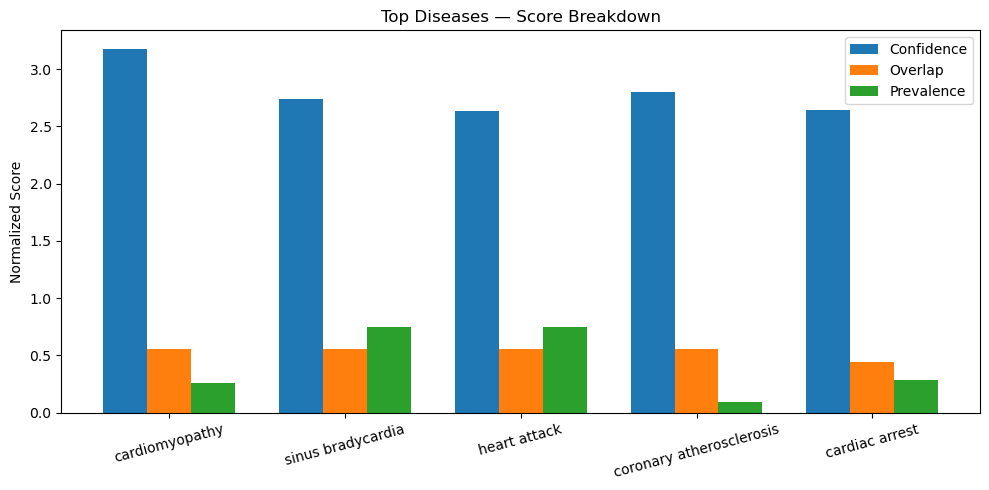

In [64]:
import matplotlib.pyplot as plt

# Run diagnosis logic first
test_input = "I feel chest pain and irregular heartbeat"
matched = extract_symptoms(test_input)
results = rank_diseases(matched, top_n=5)

# Extract parts
labels = [r['disease'] for r in results]
confidence = [r['confidence'] for r in results]
overlap = [r['overlap'] for r in results]
prevalence = [r['prevalence'] for r in results]

x = range(len(labels))
bar_width = 0.25

# Plot
plt.figure(figsize=(10, 5))
plt.bar(x, confidence, width=bar_width, label='Confidence')
plt.bar([i + bar_width for i in x], overlap, width=bar_width, label='Overlap')
plt.bar([i + 2*bar_width for i in x], prevalence, width=bar_width, label='Prevalence')

plt.xticks([i + bar_width for i in x], labels, rotation=15)
plt.title("Top Diseases — Score Breakdown")
plt.ylabel("Normalized Score")
plt.legend()
plt.tight_layout()
plt.show()